In [1]:
# !pip install --pre torch -f  https://download.pytorch.org/whl/nightly/cu101/torch-1.7.0.dev20200626%2Bcu101-cp36-cp36m-linux_x86_64.whl

In [2]:
# !pip uninstall --y torch torchvision
# !pip install --pre torchvision -f  https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

In [3]:
# memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize

# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()

# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#   process = psutil.Process(os.getpid())
#   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

# printm()

In [4]:
import torch
print ( torch.__version__)
import torch.nn as nn 
import time 
import sys 
import os 
from importlib import reload 

import torch.optim as optim 
import numpy as np

mode = "COLAB"

if mode == "COLAB":
    root_path = '/content/drive/My Drive/Projects/BGS'
    root_data_path = os.path.join ( root_path, "DATA")
    root_out_path = os.path.join ( root_path, "outputs")
    if not os.path.exists ( root_out_path ):
        os.mkdir ( root_out_path ) 
        
    # append path 
    sys.path.append ( root_path )

else:
    root_path = "./"
    root_data_path = os.path.join ( root_path, "DATA")
    root_out_path = './outputs'
    if not os.path.exists ( root_out_path ):
        os.mkdir ( root_out_path )
 


1.7.0+cu101


In [5]:
#---------------------------------------------------------------
# reload these in colab for change update without runtime restart
#----------------------------------------------------------------
import data; reload ( data )
import FCNN; reload ( FCNN )
import loss; reload ( loss )
import utils; reload ( utils )
from utils import *

from data import Data 
from FCNN import Net 
from loss import Jaccard 
import cv2

In [6]:
net_name = "net-7"
resume_training = True 

# files paths 
train_losses_path = os.path.join ( root_out_path, "train-losses-" + net_name + ".npy") 
val_losses_path = os.path.join ( root_out_path, "val-losses-" + net_name + ".npy") 
model_weights_path = os.path.join ( root_out_path, "weights-" + net_name + ".pt") 
train_indices_path = os.path.join ( root_out_path, "train_indices.npy") 
val_indices_path = os.path.join ( root_out_path, "val_indices.npy")

In [7]:
#-----------
# untar
#---------

# !tar xvf /content/drive/My\ Drive/Projects/BGS/dynamic.tar -C /content/drive/My\ Drive/Projects/BGS/DATA/

In [8]:
#-------------
# checkpoint
#-------------
import os 
import numpy as np 

def checkpoint( net, train_losses: list or 'np array', val_losses : list or 'np array ', verbose = True) -> None:
    # save weights
    if net is not None:
        torch.save( net.state_dict(), model_weights_path )

    # save train losses 
    if train_losses is not None:
        np.save(train_losses_path, np.array ( train_losses ) ) 

    # save val losses 
    if val_losses is not None:
        np.save(val_losses_path, np.array ( val_losses ) ) 
        
    if verbose:
        print(f"\n --checkpoint created for {net_name}") 

# checkpoint ( None, [1], [1] )

In [9]:
#------------------
# dataset iterator 
#------------------

from torch.utils.data import DataLoader 
from sklearn.model_selection import train_test_split 
from data import Data 
import os 

# create two datasets
# choose subset indices using train_test_split
# create two subsets from indices in two datasets : 
# remember that if you try to do this with single instance, 
# they are allocated same memory and variable will not change after subset i.e mode variable can't be changed for both 

def getDataLoader( train_batch_size = 16, val_batch_size = 8 ):
    
    #----------------------
    # divide up the folders
    #----------------------
    all_data_folders = os.listdir ( root_data_path )
    val_folders = [ 'pedestrians', 'sofa' ] 
    train_folders = list ( set ( all_data_folders ).difference ( set ( val_folders ) ) ) 

    print(f"train dataset...")
    d_train = Data ( root_dir = root_data_path, folders_name= train_folders, mode = "train", outputs_dir= root_out_path) 
    print(f"val dataset...")
    d_val = Data ( root_dir = root_data_path, folders_name= val_folders, mode = "val", outputs_dir= root_out_path ) 

    print(f"train_size : { len(d_train) }, val size : {len ( d_val ) }")
    train_dataloader = DataLoader(  d_train, batch_size = train_batch_size , shuffle = True, num_workers = 4 ) 
    val_dataloader = DataLoader ( d_val, batch_size = val_batch_size, shuffle = True , num_workers = 4 )

    return train_dataloader, val_dataloader  

In [10]:
train_dataloader, val_dataloader = getDataLoader ( train_batch_size  = 16, val_batch_size = 8 ) 

train dataset...
1. copyMachine : useful frames - start : 499, end : 3399 
2. tramCrossroad_1fps : useful frames - start : 399, end : 649 
3. tunnelExit_0_35fps : useful frames - start : 1999, end : 2999 
4. streetLight : useful frames - start : 174, end : 3199 
5. winterDriveway : useful frames - start : 999, end : 2499 
6. peopleInShade : useful frames - start : 249, end : 1198 
7. fountain01 : useful frames - start : 399, end : 1183 
8. overpass : useful frames - start : 999, end : 2999 
9. bungalows : useful frames - start : 299, end : 1699 
10. winterStreet : useful frames - start : 899, end : 1349 
11. abandonedBox : useful frames - start : 2449, end : 4499 
12. fall : useful frames - start : 999, end : 3999 
13. busyBoulvard : useful frames - start : 729, end : 1744 
14. tramstop : useful frames - start : 1319, end : 3199 
15. backdoor : useful frames - start : 399, end : 1999 
16. bridgeEntry : useful frames - start : 999, end : 1749 
17. streetCornerAtNight : useful frames - s

In [11]:
#-------------------------
# unknown motion analysis 
#------------------------
# for i, (inputs, outputs ) in enumerate ( train_dataloader ):
#     if i == 10:
#         break 
#     continue 

In [12]:
#-----------------
# model and device 
#------------------
# in case previous weights are to be used 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device available : {device}")

net = Net()
net.to ( device ) 
if resume_training:
    flag = net.load_state_dict ( torch.load ( model_weights_path ) )
    print( flag )
print ( net )

device available : cuda
<All keys matched successfully>
Net(
  (b1): Sequential(
    (0): Conv2d(6, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (b2): Sequential(
    (0): Conv2d(56, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (b3): Sequential(
    (0): Conv2d(112, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (b4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (final_layer): Sequential(
    (0): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    (1): Sigmoid()
  )
)


In [13]:
#----------------------------
# optimizer and loss function 
#----------------------------
criterion = Jaccard( smooth = 1000 ) 

optimizer = optim.Adam(net.parameters(), 
                       lr=0.001, 
                       betas=(0.9, 0.999), 
                       eps=1e-08, 
                       weight_decay=0, 
                       amsgrad=False
                       )

In [14]:
#-------------
# validation
#-------------
from tqdm import tqdm 

if resume_training:
    val_losses = list ( np.load ( val_losses_path ) ) 
else:
    val_losses = [ 0 ] 

@torch.no_grad()
def validate():
    net.eval() 
    eval_run_loss = 0 
    tqdm_test_iter = tqdm ( val_dataloader, position = 0, leave = True )

    for i, data in enumerate ( tqdm_test_iter ): 
       
        inputs, masks = data 

        inputs = inputs.to (device) 
        masks = masks.to(device)
        outputs = net( inputs )
        try:
            temp_l = criterion( y_true = masks, y_pred = outputs )
        except:
            print(f'''
                    inputs : {inputs.shape}
                    masks : {masks.shape}
                    outputs : {outputs.shape}
                    ''')
            raise ( Exception ("loss calc error"))

        eval_run_loss += temp_l.detach().cpu().numpy() 
        tqdm_test_iter.set_description(f"tloss:{np.round(eval_run_loss / (i+1), decimals=2)}")  

        if i % 100 == 0:
            #--------------------
            # show the outputs
            #--------------------
            true_mask = masks.cpu().squeeze().numpy() 
            indices_not_roi = np.where ( true_mask == 0.85 )

            pred_mask = outputs.cpu().detach().numpy()
            
            # post process each prediction via median filter of size 9 
            for i in range ( pred_mask.shape[0] ):
                pred_mask[i] = ( cv2.medianBlur( np.uint8 ( pred_mask[i] * 255 ) , 9 ) / 255.0 ) 

            pred_mask [ pred_mask >= 0.5 ] = 1.0 
            pred_mask [ pred_mask  < 0.5 ] = 0.0 
            pred_mask [ indices_not_roi ] = 0.85 

            # background and raw image
            inputs = inputs.cpu().numpy() 
            bg = inputs[:, :3, :, :]; bg = bg.transpose ( (0, 2, 3, 1) ); bg = bg.squeeze() 
            raw = inputs[:, 3:, :, :]; raw = raw.transpose ( (0, 2, 3, 1) ); raw = raw.squeeze() 

            # save
            # saving to root_out_path/Images/subfolderName/prefix-postfix.png
            # postfix = len(files) already present in the "subfolderName" 
            show(matrices = [ bg, raw, true_mask, pred_mask ], 
                title = f"validation at epoch {len(val_losses)}",
                descriptions = None,
                root_out_path = root_out_path,
                prefix = None,
                subfolderName = "validation",
                epochNum = f"{len(val_losses)}",
                show_plots = False 
                )

    # update the val losses
    val_losses.append( eval_run_loss / ( i + 1 ) )
    net.train()  

In [15]:
# validate() 
# checkpoint(net, train_losses = None, val_losses = val_losses, verbose = True)

In [16]:
# import utils; reload ( utils )
# from utils import *
# validate() 

# print ( len(val_losses)) 
# print ( len(train_losses))

  0%|          | 0/2977 [00:00<?, ?it/s]



----------------------
epoch : 25


rloss: 4.59:   0%|          | 1/2977 [00:15<13:12:12, 15.97s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/24.png


rloss: 4.55:   3%|▎         | 101/2977 [04:07<3:02:49,  3.81s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/25.png


rloss: 4.28:   7%|▋         | 201/2977 [07:53<3:25:48,  4.45s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/26.png


rloss: 4.37:  10%|█         | 301/2977 [11:34<2:22:26,  3.19s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/27.png


rloss: 4.35:  13%|█▎        | 401/2977 [15:15<2:14:17,  3.13s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/28.png


rloss: 4.33:  17%|█▋        | 501/2977 [19:01<2:11:07,  3.18s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/29.png


rloss: 4.31:  20%|██        | 601/2977 [22:40<2:16:18,  3.44s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/30.png


rloss: 4.35:  24%|██▎       | 701/2977 [26:24<2:06:53,  3.35s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/31.png


rloss: 4.42:  27%|██▋       | 801/2977 [30:01<2:03:57,  3.42s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/32.png


rloss: 4.48:  30%|███       | 901/2977 [33:42<2:02:30,  3.54s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/33.png


rloss: 4.49:  34%|███▎      | 1001/2977 [37:23<2:01:24,  3.69s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/34.png


rloss: 4.49:  37%|███▋      | 1101/2977 [40:56<1:36:27,  3.08s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/35.png


rloss: 4.48:  40%|████      | 1201/2977 [44:33<1:38:44,  3.34s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/36.png


rloss: 4.49:  44%|████▎     | 1301/2977 [48:14<1:45:39,  3.78s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/37.png


rloss: 4.53:  47%|████▋     | 1401/2977 [51:49<1:37:47,  3.72s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/38.png


rloss: 4.59:  50%|█████     | 1501/2977 [55:35<1:52:49,  4.59s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/39.png


rloss: 4.59:  54%|█████▍    | 1601/2977 [59:16<1:24:53,  3.70s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/40.png


rloss: 4.64:  57%|█████▋    | 1701/2977 [1:02:50<1:10:28,  3.31s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/41.png


rloss: 4.64:  60%|██████    | 1801/2977 [1:06:32<1:05:00,  3.32s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/42.png


rloss: 4.63:  64%|██████▍   | 1901/2977 [1:10:12<1:02:28,  3.48s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/43.png


rloss: 4.67:  67%|██████▋   | 2001/2977 [1:13:50<51:10,  3.15s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/44.png


rloss: 4.67:  71%|███████   | 2101/2977 [1:17:31<58:02,  3.98s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/45.png


rloss: 4.66:  74%|███████▍  | 2201/2977 [1:21:06<40:42,  3.15s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/46.png


rloss: 4.65:  77%|███████▋  | 2301/2977 [1:24:43<36:40,  3.26s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/47.png


rloss: 4.62:  81%|████████  | 2401/2977 [1:28:31<34:19,  3.58s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/48.png


rloss: 4.63:  84%|████████▍ | 2501/2977 [1:32:07<25:30,  3.21s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/49.png


rloss: 4.63:  87%|████████▋ | 2601/2977 [1:35:44<22:08,  3.53s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/50.png


rloss: 4.63:  91%|█████████ | 2701/2977 [1:39:26<17:14,  3.75s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/51.png


rloss: 4.61:  94%|█████████▍| 2801/2977 [1:43:08<09:50,  3.35s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/52.png


rloss: 4.62:  97%|█████████▋| 2901/2977 [1:46:46<04:34,  3.62s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 25/53.png


tloss:47.43:   0%|          | 1/382 [00:08<52:00,  8.19s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 25/0.png


tloss:47.86:  26%|██▋       | 101/382 [02:35<16:00,  3.42s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 25/1.png


tloss:47.66:  53%|█████▎    | 201/382 [04:46<07:34,  2.51s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 25/2.png


tloss:47.23:  79%|███████▉  | 301/382 [07:03<01:58,  1.46s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 25/3.png


tloss:48.22: 100%|██████████| 382/382 [08:52<00:00,  1.39s/it]


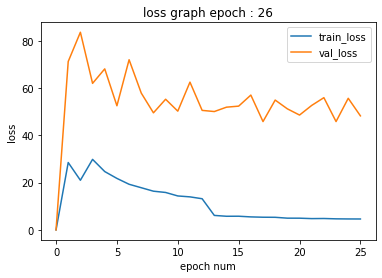

  0%|          | 0/2977 [00:00<?, ?it/s]


        average train loss ( last 3 ): [4.68 4.64 4.62] 
        average val loss ( last 3 ): [45.81 55.65 48.22]
    

 --checkpoint created for net-7


----------------------
epoch : 26


rloss: 1.87:   0%|          | 1/2977 [00:07<5:54:15,  7.14s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/0.png


rloss: 4.35:   3%|▎         | 101/2977 [02:50<2:12:58,  2.77s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/1.png


rloss: 4.51:   7%|▋         | 201/2977 [05:37<3:03:27,  3.97s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/2.png


rloss: 4.21:  10%|█         | 301/2977 [08:20<2:04:20,  2.79s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/3.png


rloss: 4.2:  13%|█▎        | 401/2977 [11:03<2:01:52,  2.84s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/4.png


rloss: 4.22:  17%|█▋        | 501/2977 [13:46<1:53:11,  2.74s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/5.png


rloss: 4.36:  20%|██        | 601/2977 [16:29<1:52:42,  2.85s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/6.png


rloss: 4.4:  24%|██▎       | 701/2977 [19:12<1:46:03,  2.80s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/7.png


rloss: 4.44:  27%|██▋       | 801/2977 [21:55<1:44:13,  2.87s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/8.png


rloss: 4.49:  30%|███       | 901/2977 [24:38<1:34:18,  2.73s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/9.png


rloss: 4.47:  34%|███▎      | 1001/2977 [27:21<1:35:20,  2.90s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/10.png


rloss: 4.43:  37%|███▋      | 1101/2977 [30:04<1:25:29,  2.73s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/11.png


rloss: 4.44:  40%|████      | 1201/2977 [32:47<1:22:36,  2.79s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/12.png


rloss: 4.42:  44%|████▎     | 1301/2977 [35:31<1:23:57,  3.01s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/13.png


rloss: 4.39:  47%|████▋     | 1401/2977 [38:14<1:13:28,  2.80s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/14.png


rloss: 4.41:  50%|█████     | 1501/2977 [40:57<1:08:42,  2.79s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/15.png


rloss: 4.4:  54%|█████▍    | 1601/2977 [43:40<1:04:30,  2.81s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/16.png


rloss: 4.41:  57%|█████▋    | 1701/2977 [46:24<1:05:26,  3.08s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/17.png


rloss: 4.45:  60%|██████    | 1801/2977 [49:07<54:51,  2.80s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/18.png


rloss: 4.45:  64%|██████▍   | 1901/2977 [51:50<49:24,  2.76s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/19.png


rloss: 4.44:  67%|██████▋   | 2001/2977 [54:33<46:20,  2.85s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/20.png


rloss: 4.43:  71%|███████   | 2101/2977 [57:16<40:23,  2.77s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/21.png


rloss: 4.42:  74%|███████▍  | 2201/2977 [1:00:00<40:03,  3.10s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/22.png


rloss: 4.42:  77%|███████▋  | 2301/2977 [1:02:43<31:32,  2.80s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/23.png


rloss: 4.4:  81%|████████  | 2401/2977 [1:05:26<26:25,  2.75s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/24.png


rloss: 4.4:  84%|████████▍ | 2501/2977 [1:08:09<22:01,  2.78s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/25.png


rloss: 4.4:  87%|████████▋ | 2601/2977 [1:10:51<17:22,  2.77s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/26.png


rloss: 4.39:  91%|█████████ | 2701/2977 [1:13:34<12:50,  2.79s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/27.png


rloss: 4.39:  94%|█████████▍| 2801/2977 [1:16:18<09:19,  3.18s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/28.png


rloss: 4.39:  97%|█████████▋| 2901/2977 [1:19:01<03:30,  2.77s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 26/29.png


tloss:46.64:   0%|          | 1/382 [00:02<18:15,  2.88s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 26/0.png


tloss:55.59:  26%|██▋       | 101/382 [00:29<03:47,  1.24it/s]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 26/1.png


tloss:56.09:  53%|█████▎    | 201/382 [00:55<02:28,  1.22it/s]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 26/2.png


tloss:56.15:  79%|███████▉  | 301/382 [01:21<01:06,  1.22it/s]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 26/3.png


tloss:56.84: 100%|██████████| 382/382 [01:41<00:00,  3.77it/s]


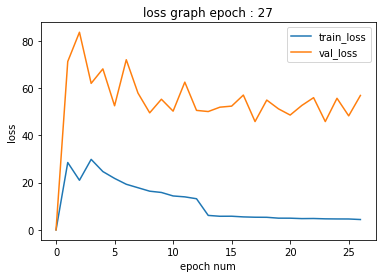

  0%|          | 0/2977 [00:00<?, ?it/s]


        average train loss ( last 3 ): [4.64 4.62 4.39] 
        average val loss ( last 3 ): [55.65 48.22 56.84]
    

 --checkpoint created for net-7


----------------------
epoch : 27


rloss: 7.47:   0%|          | 1/2977 [00:07<6:02:00,  7.30s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/0.png


rloss: 4.96:   3%|▎         | 101/2977 [02:50<2:13:05,  2.78s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/1.png


rloss: 4.65:   7%|▋         | 201/2977 [05:32<2:06:40,  2.74s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/2.png


rloss: 4.8:  10%|█         | 301/2977 [08:19<2:55:27,  3.93s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/3.png


rloss: 4.7:  13%|█▎        | 401/2977 [11:02<2:00:10,  2.80s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/4.png


rloss: 4.62:  17%|█▋        | 501/2977 [13:45<1:55:26,  2.80s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/5.png


rloss: 4.58:  20%|██        | 601/2977 [16:28<1:56:20,  2.94s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/6.png


rloss: 4.57:  24%|██▎       | 701/2977 [19:11<1:45:28,  2.78s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/7.png


rloss: 4.5:  27%|██▋       | 801/2977 [21:54<1:44:35,  2.88s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/8.png


rloss: 4.46:  30%|███       | 901/2977 [24:37<1:36:01,  2.78s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/9.png


rloss: 4.45:  34%|███▎      | 1001/2977 [27:19<1:31:08,  2.77s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/10.png


rloss: 4.35:  37%|███▋      | 1101/2977 [30:03<1:32:54,  2.97s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/11.png


rloss: 4.33:  40%|████      | 1201/2977 [32:46<1:23:52,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/12.png


rloss: 4.31:  44%|████▎     | 1301/2977 [35:29<1:19:08,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/13.png


rloss: 4.33:  47%|████▋     | 1401/2977 [38:13<1:20:23,  3.06s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/14.png


rloss: 4.32:  50%|█████     | 1501/2977 [40:55<1:08:47,  2.80s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/15.png


rloss: 4.34:  54%|█████▍    | 1601/2977 [43:38<1:04:39,  2.82s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/16.png


rloss: 4.34:  57%|█████▋    | 1701/2977 [46:21<59:53,  2.82s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/17.png


rloss: 4.37:  60%|██████    | 1801/2977 [49:05<1:01:06,  3.12s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/18.png


rloss: 4.36:  64%|██████▍   | 1901/2977 [51:49<50:13,  2.80s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/19.png


rloss: 4.34:  67%|██████▋   | 2001/2977 [54:32<45:19,  2.79s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/20.png


rloss: 4.33:  71%|███████   | 2101/2977 [57:15<41:16,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/21.png


rloss: 4.3:  74%|███████▍  | 2201/2977 [59:58<36:02,  2.79s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/22.png


rloss: 4.31:  77%|███████▋  | 2301/2977 [1:02:42<36:07,  3.21s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/23.png


rloss: 4.3:  81%|████████  | 2401/2977 [1:05:25<26:55,  2.81s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/24.png


rloss: 4.3:  84%|████████▍ | 2501/2977 [1:08:08<22:24,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/25.png


rloss: 4.3:  87%|████████▋ | 2601/2977 [1:10:51<17:43,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/26.png


rloss: 4.31:  91%|█████████ | 2701/2977 [1:13:34<12:48,  2.78s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/27.png


rloss: 4.28:  94%|█████████▍| 2801/2977 [1:16:17<08:18,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/28.png


rloss: 4.3:  97%|█████████▋| 2901/2977 [1:19:02<04:07,  3.26s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 27/29.png


tloss:50.78:   0%|          | 1/382 [00:03<19:11,  3.02s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 27/0.png


tloss:50.21:  26%|██▋       | 101/382 [00:29<03:53,  1.20it/s]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 27/1.png


tloss:49.74:  53%|█████▎    | 201/382 [00:55<02:32,  1.18it/s]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 27/2.png


tloss:49.66:  79%|███████▉  | 301/382 [01:22<01:08,  1.18it/s]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 27/3.png


tloss:50.63: 100%|██████████| 382/382 [01:41<00:00,  3.75it/s]


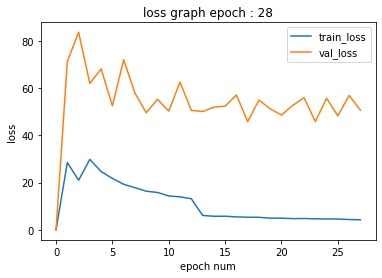

  0%|          | 0/2977 [00:00<?, ?it/s]


        average train loss ( last 3 ): [4.62 4.39 4.29] 
        average val loss ( last 3 ): [48.22 56.84 50.63]
    

 --checkpoint created for net-7


----------------------
epoch : 28


rloss: 2.57:   0%|          | 1/2977 [00:07<6:09:42,  7.45s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/0.png


rloss: 3.97:   3%|▎         | 101/2977 [02:50<2:15:22,  2.82s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/1.png


rloss: 4.21:   7%|▋         | 201/2977 [05:33<2:11:00,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/2.png


rloss: 4.19:  10%|█         | 301/2977 [08:16<2:05:14,  2.81s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/3.png


rloss: 4.35:  13%|█▎        | 401/2977 [10:59<2:01:48,  2.84s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/4.png


rloss: 4.42:  17%|█▋        | 501/2977 [13:46<2:51:32,  4.16s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/5.png


rloss: 4.39:  20%|██        | 601/2977 [16:30<1:51:32,  2.82s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/6.png


rloss: 4.38:  24%|██▎       | 701/2977 [19:13<1:50:25,  2.91s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/7.png


rloss: 4.39:  27%|██▋       | 801/2977 [21:56<1:41:59,  2.81s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/8.png


rloss: 4.39:  30%|███       | 901/2977 [24:39<1:43:42,  3.00s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/9.png


rloss: 4.48:  34%|███▎      | 1001/2977 [27:22<1:31:46,  2.79s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/10.png


rloss: 4.42:  37%|███▋      | 1101/2977 [30:05<1:28:10,  2.82s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/11.png


rloss: 4.42:  40%|████      | 1201/2977 [32:49<1:29:32,  3.03s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/12.png


rloss: 4.45:  44%|████▎     | 1301/2977 [35:32<1:20:33,  2.88s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/13.png


rloss: 4.43:  47%|████▋     | 1401/2977 [38:15<1:14:23,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/14.png


rloss: 4.45:  50%|█████     | 1501/2977 [40:58<1:09:38,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/15.png


rloss: 4.49:  54%|█████▍    | 1601/2977 [43:42<1:10:44,  3.08s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/16.png


rloss: 4.49:  57%|█████▋    | 1701/2977 [46:25<1:00:14,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/17.png


rloss: 4.5:  60%|██████    | 1801/2977 [49:08<54:48,  2.80s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/18.png


rloss: 4.5:  64%|██████▍   | 1901/2977 [51:51<50:21,  2.81s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/19.png


rloss: 4.48:  67%|██████▋   | 2001/2977 [54:35<50:49,  3.12s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/20.png


rloss: 4.46:  71%|███████   | 2101/2977 [57:18<41:17,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/21.png


rloss: 4.46:  74%|███████▍  | 2201/2977 [1:00:01<36:26,  2.82s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/22.png


rloss: 4.43:  77%|███████▋  | 2301/2977 [1:02:43<31:19,  2.78s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/23.png


rloss: 4.43:  81%|████████  | 2401/2977 [1:05:26<26:59,  2.81s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/24.png


rloss: 4.43:  84%|████████▍ | 2501/2977 [1:08:11<25:48,  3.25s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/25.png


rloss: 4.44:  87%|████████▋ | 2601/2977 [1:10:54<17:42,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/26.png


rloss: 4.41:  91%|█████████ | 2701/2977 [1:13:37<12:58,  2.82s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/27.png


rloss: 4.41:  94%|█████████▍| 2801/2977 [1:16:19<08:18,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/28.png


rloss: 4.4:  97%|█████████▋| 2901/2977 [1:19:02<03:33,  2.81s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 28/29.png


tloss:58.99:   0%|          | 1/382 [00:03<19:06,  3.01s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 28/0.png


tloss:50.75:  26%|██▋       | 101/382 [00:29<03:55,  1.19it/s]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 28/1.png


tloss:50.62:  53%|█████▎    | 201/382 [00:55<02:34,  1.17it/s]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 28/2.png


tloss:50.59:  79%|███████▉  | 301/382 [01:22<01:08,  1.18it/s]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 28/3.png


tloss:51.5: 100%|██████████| 382/382 [01:41<00:00,  3.75it/s]


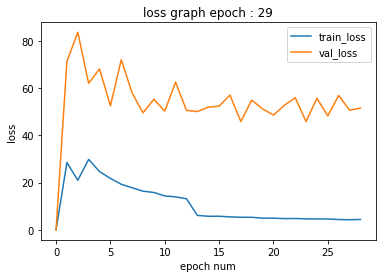

  0%|          | 0/2977 [00:00<?, ?it/s]


        average train loss ( last 3 ): [4.39 4.29 4.42] 
        average val loss ( last 3 ): [56.84 50.63 51.5 ]
    

 --checkpoint created for net-7


----------------------
epoch : 29


rloss: 2.52:   0%|          | 1/2977 [00:11<9:29:33, 11.48s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/0.png


rloss: 4.88:   3%|▎         | 101/2977 [02:52<2:18:59,  2.90s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/1.png


rloss: 4.69:   7%|▋         | 201/2977 [05:34<2:11:36,  2.84s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/2.png


rloss: 4.39:  10%|█         | 301/2977 [08:16<2:08:11,  2.87s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/3.png


rloss: 4.21:  13%|█▎        | 401/2977 [10:58<2:04:40,  2.90s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/4.png


rloss: 4.29:  17%|█▋        | 501/2977 [13:40<1:54:01,  2.76s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/5.png


rloss: 4.18:  20%|██        | 601/2977 [16:22<1:56:16,  2.94s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/6.png


rloss: 4.18:  24%|██▎       | 701/2977 [19:04<1:47:02,  2.82s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/7.png


rloss: 4.26:  27%|██▋       | 801/2977 [21:47<1:48:00,  2.98s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/8.png


rloss: 4.32:  30%|███       | 901/2977 [24:28<1:37:23,  2.81s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/9.png


rloss: 4.28:  34%|███▎      | 1001/2977 [27:11<1:37:28,  2.96s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/10.png


rloss: 4.32:  37%|███▋      | 1101/2977 [29:52<1:28:22,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/11.png


rloss: 4.34:  40%|████      | 1201/2977 [32:34<1:23:30,  2.82s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/12.png


rloss: 4.28:  44%|████▎     | 1301/2977 [35:17<1:23:43,  3.00s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/13.png


rloss: 4.32:  47%|████▋     | 1401/2977 [37:58<1:14:25,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/14.png


rloss: 4.35:  50%|█████     | 1501/2977 [40:40<1:10:05,  2.85s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/15.png


rloss: 4.33:  54%|█████▍    | 1601/2977 [43:23<1:04:14,  2.80s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/16.png


rloss: 4.34:  57%|█████▋    | 1701/2977 [46:06<1:06:39,  3.13s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/17.png


rloss: 4.33:  60%|██████    | 1801/2977 [48:50<55:38,  2.84s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/18.png


rloss: 4.32:  64%|██████▍   | 1901/2977 [51:33<50:52,  2.84s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/19.png


rloss: 4.36:  67%|██████▋   | 2001/2977 [54:16<46:29,  2.86s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/20.png


rloss: 4.35:  71%|███████   | 2101/2977 [57:00<41:17,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/21.png


rloss: 4.35:  74%|███████▍  | 2201/2977 [59:44<40:55,  3.16s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/22.png


rloss: 4.36:  77%|███████▋  | 2301/2977 [1:02:27<31:53,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/23.png


rloss: 4.33:  81%|████████  | 2401/2977 [1:05:10<27:00,  2.81s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/24.png


rloss: 4.33:  84%|████████▍ | 2501/2977 [1:07:53<22:18,  2.81s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/25.png


rloss: 4.33:  87%|████████▋ | 2601/2977 [1:10:36<17:39,  2.82s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/26.png


rloss: 4.32:  91%|█████████ | 2701/2977 [1:13:19<13:02,  2.84s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/27.png


rloss: 4.31:  94%|█████████▍| 2801/2977 [1:16:04<09:28,  3.23s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/28.png


rloss: 4.29:  97%|█████████▋| 2901/2977 [1:18:47<03:35,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 29/29.png


tloss:61.98:   0%|          | 1/382 [00:03<19:37,  3.09s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 29/0.png


tloss:56.41:  26%|██▋       | 101/382 [00:29<04:01,  1.16it/s]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 29/1.png


tloss:56.39:  53%|█████▎    | 201/382 [00:55<02:34,  1.17it/s]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 29/2.png


tloss:56.05:  79%|███████▉  | 301/382 [01:22<01:08,  1.18it/s]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/validation/epoch 29/3.png


tloss:55.79: 100%|██████████| 382/382 [01:42<00:00,  3.74it/s]


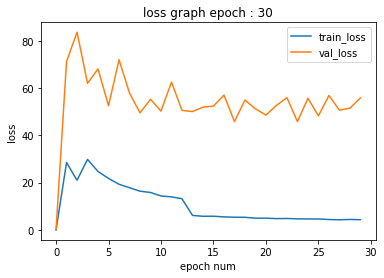

  0%|          | 0/2977 [00:00<?, ?it/s]


        average train loss ( last 3 ): [4.29 4.42 4.32] 
        average val loss ( last 3 ): [50.63 51.5  55.79]
    

 --checkpoint created for net-7


----------------------
epoch : 30


rloss: 8.52:   0%|          | 1/2977 [00:07<6:31:24,  7.89s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/0.png


rloss: 5.01:   3%|▎         | 101/2977 [02:51<2:16:57,  2.86s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/1.png


rloss: 4.73:   7%|▋         | 201/2977 [05:34<2:12:39,  2.87s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/2.png


rloss: 4.66:  10%|█         | 301/2977 [08:21<3:03:01,  4.10s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/3.png


rloss: 4.54:  13%|█▎        | 401/2977 [11:05<2:03:55,  2.89s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/4.png


rloss: 4.47:  17%|█▋        | 501/2977 [13:48<1:56:35,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/5.png


rloss: 4.45:  20%|██        | 601/2977 [16:31<1:56:12,  2.93s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/6.png


rloss: 4.35:  24%|██▎       | 701/2977 [19:14<1:47:22,  2.83s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/7.png


rloss: 4.4:  27%|██▋       | 801/2977 [21:58<1:47:44,  2.97s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/8.png


rloss: 4.41:  30%|███       | 901/2977 [24:41<1:37:09,  2.81s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/9.png


rloss: 4.44:  34%|███▎      | 1001/2977 [27:24<1:33:29,  2.84s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/10.png


rloss: 4.41:  37%|███▋      | 1101/2977 [30:08<1:35:26,  3.05s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/11.png


rloss: 4.38:  40%|████      | 1201/2977 [32:51<1:24:50,  2.87s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/12.png


rloss: 4.38:  44%|████▎     | 1301/2977 [35:34<1:18:39,  2.82s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/13.png


rloss: 4.35:  47%|████▋     | 1401/2977 [38:18<1:20:37,  3.07s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/14.png


rloss: 4.36:  50%|█████     | 1501/2977 [41:01<1:09:19,  2.82s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/15.png


rloss: 4.35:  54%|█████▍    | 1601/2977 [43:44<1:04:27,  2.81s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/16.png


rloss: 4.36:  57%|█████▋    | 1701/2977 [46:27<1:00:30,  2.84s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/17.png


rloss: 4.34:  60%|██████    | 1801/2977 [49:11<1:01:04,  3.12s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/18.png


rloss: 4.31:  64%|██████▍   | 1901/2977 [51:54<51:08,  2.85s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/19.png


rloss: 4.29:  67%|██████▋   | 2001/2977 [54:37<46:09,  2.84s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/20.png


rloss: 4.3:  71%|███████   | 2101/2977 [57:21<41:37,  2.85s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/21.png


rloss: 4.28:  74%|███████▍  | 2201/2977 [1:00:04<36:56,  2.86s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/22.png


rloss: 4.28:  77%|███████▋  | 2301/2977 [1:02:48<36:07,  3.21s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/23.png


rloss: 4.28:  81%|████████  | 2401/2977 [1:05:31<27:14,  2.84s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/24.png


rloss: 4.27:  84%|████████▍ | 2501/2977 [1:08:14<22:20,  2.82s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/25.png


rloss: 4.26:  87%|████████▋ | 2601/2977 [1:10:57<17:53,  2.85s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/26.png


rloss: 4.25:  91%|█████████ | 2701/2977 [1:13:41<13:06,  2.85s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/27.png


rloss: 4.31:  94%|█████████▍| 2801/2977 [1:16:24<08:19,  2.84s/it]

figure saved to /content/drive/My Drive/Projects/BGS/outputs/Images/train/epoch 30/28.png


rloss: 4.31:  96%|█████████▋| 2871/2977 [1:18:15<02:48,  1.59s/it]

KeyboardInterrupt: ignored

In [17]:
#--------------
# train 
#--------------
from IPython.display import clear_output 

from tqdm import tqdm 
num_epochs = 100

if resume_training:
    train_losses = list ( np.load ( train_losses_path ) )
else:
    train_losses = [ 0 ]

for epoch in range ( num_epochs ) :  # loop over the dataset multiple times
    print("\n\n----------------------")
    print(f"epoch : { len(train_losses)}")
    running_loss = 0.0 

    tqdm_iter =  tqdm (  train_dataloader , position = 0, leave = True )
    for i, data in enumerate ( tqdm_iter ) :
        # if i == 1: break
        # data is a list of [inputs, labels]
        inputs, masks = data 
        # print(f"inputs shape : { inputs.shape }, masks shape : {masks.shape}")
        inputs = inputs.to(device)
        masks =  masks.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(y_true = masks, y_pred = outputs )
        loss.backward()
        optimizer.step()

        # update loss 
        running_loss += loss.cpu().detach().numpy()
        tqdm_iter.set_description (f"rloss: { np.round( running_loss/(i+1), decimals=2) }")

        if i % 100 == 0:
            checkpoint(net, None, None, verbose = False) 

            #----------------------------------------
            # show results of the last batch trained. 
            #----------------------------------------
            # true mask 
            true_mask = masks.cpu().numpy()
            indices_not_roi = np.where ( true_mask == 0.85 ) # handiling the not roi region in pred mask 

            # predicted mask 
            pred_mask = outputs.cpu().detach().numpy()
            
            # post process each prediction via median filter of size 9 
            for i in range ( pred_mask.shape[0] ):
                pred_mask[i] = cv2.medianBlur( np.uint8 ( pred_mask[i] * 255 ) , 9 ) / 255.0 

            pred_mask [pred_mask >= 0.5 ] = 1.0       # thresholding of 0.5 
            pred_mask [ pred_mask < 0.5 ] = 0.0 
            pred_mask [ indices_not_roi ] = 0.85 

            # bg and raw 
            inputs = inputs.cpu().numpy() 
            # bg 
            bg = inputs[:,:3,:,:].transpose((0, 2,3, 1))
            # raw 
            raw = inputs[:,3:, :, :].transpose((0, 2, 3, 1)) 

            show(matrices = [bg, raw, true_mask, pred_mask],
                 title = f"train at epoch-{len(train_losses)}",
                 descriptions = None,
                 root_out_path = root_out_path,
                 prefix = None,
                 subfolderName = "train",
                 epochNum = f"{len(train_losses)}",
                 show_plots = False
                )
            
    #------------------------
    #------------------------
    
    # update train loss 
    train_losses.append ( running_loss / (i+1) )

    #----------------
    # run validation
    #----------------
    validate() 

    #------------------
    # plot loss graphs 
    #------------------
    plt.plot(train_losses, label = "train_loss")
    plt.plot(val_losses, label = "val_loss")
    plt.legend(); plt.xlabel("epoch num"); plt.ylabel("loss"); plt.title ( f"loss graph epoch : {len(train_losses)}")
    plt.savefig ( os.path.join ( root_out_path,"Images", f"loss_graph_{len(train_losses)}.png" ) ) 
    plt.show() 

    #summary
    print(f'''
        average train loss ( last 3 ): { np.round ( train_losses[-3:], decimals= 2 ) } 
        average val loss ( last 3 ): { np.round (val_losses[-3:], decimals= 2) }
    ''') 
    # break 
    checkpoint(net, train_losses, val_losses, verbose = True)

In [ ]:
# for i in range(2):
#     val_losses.pop()
#     train_losses.pop()

# print ( len(val_losses), len(train_losses) )
checkpoint( net, train_losses, val_losses )


 --checkpoint created for net-7


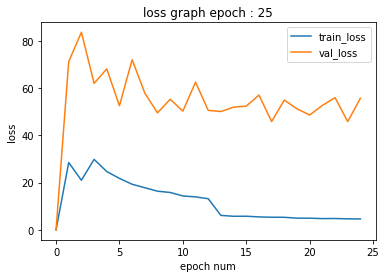

In [40]:
plt.plot(train_losses, label = "train_loss")
plt.plot(val_losses, label = "val_loss")
plt.legend(); plt.xlabel("epoch num"); plt.ylabel("loss"); plt.title ( f"loss graph epoch : {len(train_losses)}")
plt.savefig ( os.path.join ( root_out_path,"Images", f"loss_graph_{len(train_losses)}.png" ) ) 
plt.show() 

In [ ]:
#---------------
# test on images
#---------------

# while training the input hybrid of 6 channels
# was composed by first 3 channels from background image
# and last 3 channels from true imageṇ
from skimage import io 

def read ( image_filename, background_filename ):
    ''' read raw image and background image as input hybrid '''
    bg = io.imread ( background_filename )
    raw = io.imread ( image_filename )
    
    assert bg.ndim == 3 and raw.ndim == 3, "input is supposed to be of 6 channels"

    # make channel first
    bg = bg.transpose ( (2,0,1))
    raw = raw.transpose ( (2,0,1))

    # add batch axis and normalise and change dtype to float
    bg = bg[np.new_axis, :] )  / 255.0   
    raw = raw[np.new_axis, :] / 255.0 
    
    input_hybrid = torch.cat ( [ torch.tensor ( bg ), torch.tensor (raw) ], axis = 1 ) 
    return input_hybrid 

@torch.no_grad()
def forward(inputs):
    ''' returns a binary map'''
    output = net(inputs)
    output = output.detach().cpu().squeeze() 

    output[output >= 0.5 ] = 1
    output[ output < 0.5 ] = 0 
    return output 


from glob import glob 
import os 

def main( test_images_dir ):
    '''
    directory where test_images are stored
    - contain a folder named background
    - contain a folder names images 
    '''
    background_folder = os.path.join ( test_images_dir, "background" )    
    images_folder = os.path.join ( test_images_dir, "images")

    bg_image_file  = glob ( background_folder + "/*")[0] 
    images = glob ( images_folder + "/*") 

    for image_file in images:
        inputs = read ( image_file, bg_image_file ) 
        pred_mask = forward ( inputs )
        image = io.imread ( image_file )
        

In [ ]:
#--------- time check at different input shapes
#-----------------------------------------------

def timeTest():
    net.eval() 
    for s in [ 37, 224,]:
        image = torch.rand(10, 6, s, s ).cuda()
        tick = time.time()
        out = net ( image )
        tock = time.time()
        print(f'''
            time taken is : { tock - tick } 
            input size : {image.shape}
            output size : {out.shape}

            ''') 
    net.train() 
        
timeTest()


            time taken is : 0.003214597702026367 
            input size : torch.Size([10, 6, 37, 37])
            output size : torch.Size([10, 37, 37])

            

            time taken is : 0.0034532546997070312 
            input size : torch.Size([10, 6, 224, 224])
            output size : torch.Size([10, 224, 224])

            


In [ ]:
path = os.path.join ( root_out_path, "1", "4")
os.makedirs ( path )